Vinh Model

In [11]:
import pandas as pd
import numpy as np

# Create a sample DataFrame
df = pd.read_csv("pre_processed_data.csv")

# Specify the desired column order
desired_order = ['route_id','trip_id', 'direction_id', 'arrival_time', 'arrival_hour', 'arrival_minute',  'stop_lat', 'stop_lon', 'next_lat', 'next_lon', 'speed_kmh',   'segment_max_speed_kmh', 'runtime_sec', 'distance_m', 'congestion_level']

# Rearrange the columns
df = df[desired_order]

df = df.sort_values(by=['route_id','trip_id', 'direction_id'])

# -- Define the sequence length --
seq_length = 20

X_seq, Y_seq = [], []

# Initialize variables to keep track of the current trip
current_trip_id = None
current_trip_data = []

# -- Generate sequences --
for index, row in df.iterrows():
    trip_id = row['trip_id']

    # Check if we're starting a new trip
    if trip_id != current_trip_id:
        current_trip_data = []  # Reset current trip data
        current_trip_id = trip_id

    # Append the row to the current trip's data
    current_trip_data.append(row)

    # Once the current trip's data exceeds the sequence length, start creating sequences
    if len(current_trip_data) >= seq_length:
        X_seq.append(current_trip_data[:seq_length])
        Y_seq.append(current_trip_data[seq_length-1])  # Fix the index error by using [seq_length-1]

# Convert X_seq and Y_seq to NumPy arrays for further processing
X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

Epoch 1/1000
47/47 [==============================] - 5s 33ms/step - loss: 1.9693
Epoch 2/1000
47/47 [==============================] - 2s 33ms/step - loss: 1.5905
Epoch 3/1000
47/47 [==============================] - 1s 30ms/step - loss: 1.5770
Epoch 4/1000
47/47 [==============================] - 1s 30ms/step - loss: 1.5816
Epoch 5/1000
47/47 [==============================] - 1s 30ms/step - loss: 1.5807
Epoch 6/1000
47/47 [==============================] - 1s 30ms/step - loss: 1.5813
Epoch 7/1000
47/47 [==============================] - 1s 30ms/step - loss: 1.5960
Epoch 8/1000
47/47 [==============================] - 1s 30ms/step - loss: 1.5797
Epoch 9/1000
47/47 [==============================] - 2s 33ms/step - loss: 1.5782
Epoch 10/1000
47/47 [==============================] - 1s 30ms/step - loss: 1.5755
Epoch 11/1000
47/47 [==============================] - 1s 29ms/step - loss: 1.5875
Epoch 12/1000
47/47 [==============================] - 1s 29ms/step - loss: 1.5762
Epoch 13/1000

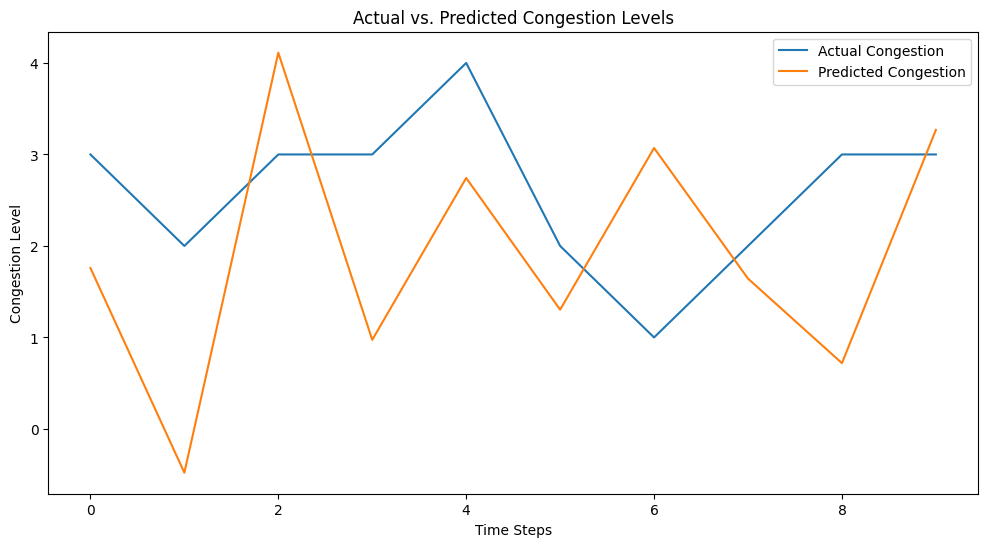

In [12]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

# -- Load file --
# FILE_PATH = os.path.join("dataset", "pre_processed_data.csv")
# df = pd.read_csv(FILE_PATH)
df = pd.read_csv("pre_processed_data.csv")

# -- sort by arrival_time for the ML LSTM model --
df['arrival_time'] = pd.to_datetime(df['arrival_time'])
df = df.sort_values(by=['route_id', 'trip_id', 'direction_id', 'arrival_time'])

# -- Select features and target --
X = df[['arrival_hour', 'arrival_minute', 'stop_lat', 'stop_lon', 'next_lat', 'next_lon', 'speed_kmh', 'segment_max_speed_kmh', 'runtime_sec', 'direction_id', 'distance_m']]
Y = df['congestion_level']

# -- Normalize feature data --
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# -- Define the sequence length --
seq_length = 20

X_seq, Y_seq = [], []

# -- Generate sequences --
for i in range(len(X) - seq_length):
    X_seq.append(X[i:i + seq_length])
    Y_seq.append(Y[i + seq_length])

X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

# Start: Cleaning data
# Define the column to check for uniformity
column_to_check = 9

# Find sequences where all rows have the same value in the specified column
unique_values = np.unique(X_seq[:, :, column_to_check], axis=1)
sequences_to_keep = np.all(unique_values == unique_values[:, 0][:, np.newaxis], axis=1)

# Filter X_seq and Y_seq
X_seq = X_seq[sequences_to_keep]
Y_seq = Y_seq[sequences_to_keep]
# End: Cleaning data

# -- Split the data into training and testing sets --
X_train, X_test, Y_train, Y_test = train_test_split(X_seq, Y_seq, test_size=0.4, random_state=42)


# -- Build Simple LSTM model (tanh vs relu) --
model = keras.Sequential([
    keras.layers.LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, X_seq.shape[2])),
    keras.layers.LSTM(50, activation='tanh', return_sequences=True),
    keras.layers.LSTM(50, activation='tanh'),
    keras.layers.Dense(1)
])

# -- Using 'adam' optimizer and 'mean_squared_error' --
model.compile(optimizer='adam', loss='mean_squared_error')

# -- Train the model, batch size = 64 is due to the times appearance of each bus trip is from 50 to 85 --
model.fit(X_train, Y_train, epochs=1000, batch_size=64)

# -- Evaluate the model on the test set --
Y_pred = model.predict(X_test)
Y_test_1d = Y_test.reshape(-1)  # Reshape to a 1D array
Y_pred_1d = Y_pred.reshape(-1)  # Reshape to a 1D array


# -- Save the trained model to a file --
model.save("model\\LSTM_1_model_saved_model")


# -- Example for making predictions --
input_data = X_test[10:20]  # Adjust the slice as needed
predicted_congestion = model.predict(input_data)

print("Predicted Congestion Level:", predicted_congestion)

# -- Plot the predicted and actual congestion levels --
plt.figure(figsize=(12, 6))
plt.plot(Y_test[10:20], label="Actual Congestion")
plt.plot(predicted_congestion, label="Predicted Congestion")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Congestion Level")
plt.title("Actual vs. Predicted Congestion Levels")
plt.show()

In [41]:
mse = mean_squared_error(Y_test_1d, Y_pred_1d)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.9844225464341847


In [36]:
# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1.4086953348521407
